# Bitcoin Price Trend Prediction with CNN

## Setup

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sn
import torch
import torchtext
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchtext

from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install tweet-preprocessor

  Obtaining dependency information for tweet-preprocessor from https://files.pythonhosted.org/packages/17/9d/71bd016a9edcef8860c607e531f30bd09b13103c7951ae73dd2bf174163c/tweet_preprocessor-0.6.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import preprocessor as tp

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yljasmine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yljasmine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yljasmine/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter, OrderedDict

## Preprocess

### Breakdown original files

The original file has more than 2GB data, we have to split and process them in batch. Data source https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets.

In [ ]:
# run in command line, data file is not included in the repo
split -l 5000000 -d tweets-with-price.csv tweets-with-price_
for i in $(find tweets-with-price_*); do mv $i "$i.csv"; done 
for i in $(find . -type f -name "tweets-with-price_*.csv" -not -name "tweets-with-price_00.csv");
    do echo -e "$(head -1 tweets-with-price_00.csv)\n$(cat $i)" > $i;
done

Read raw data to dataframe, here we choose to ignore those non-English tweets.

In [18]:
# csv files not included in the repo
origin = []
for x in range(5):
  filename = 'tweets-with-price_0{}.csv'.format(x)
  d = pd.read_csv(filename, engine='python', error_bad_lines=False,  encoding='utf-8')
  origin.append(d)

/var/folders/dv/jgp81_zd7q112t2sf_4ppk5r0000gn/T/ipykernel_48236/3279032350.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  d = pd.read_csv(filename, engine='python', error_bad_lines=False,  encoding='utf-8')
Skipping line 1130212: unexpected end of data
/var/folders/dv/jgp81_zd7q112t2sf_4ppk5r0000gn/T/ipykernel_48236/3279032350.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  d = pd.read_csv(filename, engine='python', error_bad_lines=False,  encoding='utf-8')
/var/folders/dv/jgp81_zd7q112t2sf_4ppk5r0000gn/T/ipykernel_48236/3279032350.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  d = pd.read_csv(filename, engine='python', error_bad_lines=False,  encoding='utf-8')
Skipping line 263958: NULL byt

In [14]:
print(len(origin))

5


### Clean data

Clean the raw data, including: 
* drop useless features 
* drop null data
* convert to proper data type
* convert categorical feature to numerical data
* filter data based on user followers to remove ads.

In [19]:
def clean_data(df):
  df_pre = df.drop(['source', 'user_location', 'user_description', 'user_created', 'date'], axis=1)
  print("Before:",df_pre.shape)
  df_pre = df_pre.dropna(subset=['user_name'])
  df_pre = df_pre.dropna(subset=['is_retweet'])
  df_pre['user_name'] = df_pre['user_name'].astype(str)
  df_pre["user_favourites"] = df_pre["user_favourites"].astype(float).astype(int)
  df_pre["user_followers"] = df_pre["user_followers"].astype(float).astype(int)
  df_pre["user_friends"] = df_pre["user_friends"].astype(float).astype(int)
  df_pre.user_verified.replace({'True': 1, 'False': 0}, inplace=True)
  df_pre.is_retweet.replace({'True': 1, 'False': 0}, inplace=True)
  df_pre["user_verified"] = df_pre["user_verified"].astype(int)
  df_pre["is_retweet"] = df_pre["is_retweet"].astype(int)
  df_pre = df_pre.drop(df_pre[(df_pre.user_followers < 100000)].index)
  print("After:",df_pre.shape)
  df_pre.head()
  return df_pre

Concatenate all the files into one dataframe.

In [20]:
pre = []
for df in origin:
  p = clean_data(df)
  pre.append(p)
df_pre = pd.concat(pre)

Before: (1130210, 9)
After: (11855, 9)
Before: (15471, 9)
After: (182, 9)
Before: (361936, 9)
After: (1897, 9)
Before: (46775, 9)
After: (671, 9)
Before: (48356, 9)
After: (542, 9)


In [10]:
print("Size after processing: ", df_pre.shape)

Size after processing:  (15147, 9)


In [328]:
df_pre.head()

,user_name,user_followers,user_friends,user_favourites,user_verified,text,hashtags,is_retweet,next_15min_prices
479,CryptoCurrency News,179616,697,5035,0,Someone bought a Tesla Model S in 2013 for 91....,"['BTC', 'Bitcoin']",0,"[44959.12, 44963.91, 44953.04, 44904.16, 44884..."
880,Blockstream,131970,794,12454,1,#BlockstreamAQUA is our new #Bitcoin and @Liqu...,"['BlockstreamAQUA', 'Bitcoin']",0,"[44988.75, 45019.15, 45021.52, 45088.86, 45115..."
1100,Mike Schiemer,216616,145451,79651,0,How To Potentially Profit From Bitcoin Without...,"['CFD', 'BTC', 'Bitcoin', 'Crypto']",0,"[44619.81, 44536.9, 44567.94, 44475.01, 44496...."
1326,TrendSpider,102521,1201,24073,0,$BTCUSD #Bitcoin #BTC Going down right through...,"['Bitcoin', 'BTC']",0,"[44009.61, 43872.41, 43817.88, 43897.7, 43927...."
1411,CNBC,3977144,843,612,1,"""It has to be part of the menu,"" says @JimCram...",['bitcoin'],0,"[44790.81, 44799.23, 44844.8, 44761.73, 44611...."


In [24]:
df_pre.isnull().sum()

user_name             0
user_followers        0
user_friends          0
user_favourites       0
user_verified         0
text                  0
hashtags             98
is_retweet            0
next_15min_prices     0
dtype: int64

### is_retweet

There's only one category, ie. there is no retweet in dataset, therefore remove this feature.

In [21]:
df_pre["is_retweet"].drop_duplicates()

479    0
Name: is_retweet, dtype: int64

In [22]:
df_pre = df_pre.drop(['is_retweet'], axis=1)

### Preprocess tweet

1. Use Twitter-Processor to clean the tweet, including URL/mention/hashtag removing.

In [23]:
def preprocess_tweet(text):
    text = tp.clean(text)
    return text

In [24]:
df_pre['clean_text'] = df_pre['text'].apply(preprocess_tweet)

In [237]:
df_pre.head()

,user_name,user_followers,user_friends,user_favourites,user_verified,text,hashtags,next_15min_prices,clean_text
479,CryptoCurrency News,179616,697,5035,0,Someone bought a Tesla Model S in 2013 for 91....,"['BTC', 'Bitcoin']","[44959.12, 44963.91, 44953.04, 44904.16, 44884...","Someone bought a Tesla Model S in for ($103,00..."
880,Blockstream,131970,794,12454,1,#BlockstreamAQUA is our new #Bitcoin and @Liqu...,"['BlockstreamAQUA', 'Bitcoin']","[44988.75, 45019.15, 45021.52, 45088.86, 45115...",is our new and wallet designed to be as easy a...
1100,Mike Schiemer,216616,145451,79651,0,How To Potentially Profit From Bitcoin Without...,"['CFD', 'BTC', 'Bitcoin', 'Crypto']","[44619.81, 44536.9, 44567.94, 44475.01, 44496....",How To Potentially Profit From Bitcoin Without...
1326,TrendSpider,102521,1201,24073,0,$BTCUSD #Bitcoin #BTC Going down right through...,"['Bitcoin', 'BTC']","[44009.61, 43872.41, 43817.88, 43897.7, 43927....",$BTCUSD Going down right through the anchored ...
1411,CNBC,3977144,843,612,1,"""It has to be part of the menu,"" says @JimCram...",['bitcoin'],"[44790.81, 44799.23, 44844.8, 44761.73, 44611....","""It has to be part of the menu,"" says on on co..."


In [27]:
df_pre.loc[:,['text', 'clean_text']].head()


,text,clean_text
479,Someone bought a Tesla Model S in 2013 for 91....,"Someone bought a Tesla Model S in for ($103,00..."
880,#BlockstreamAQUA is our new #Bitcoin and @Liqu...,is our new and wallet designed to be as easy a...
1100,How To Potentially Profit From Bitcoin Without...,How To Potentially Profit From Bitcoin Without...
1326,$BTCUSD #Bitcoin #BTC Going down right through...,$BTCUSD Going down right through the anchored ...
1411,"""It has to be part of the menu,"" says @JimCram...","""It has to be part of the menu,"" says on on co..."


2. Lowercase the text, remove punctuation, extra space and digits.

In [25]:
df_pre['clean_text'] = df_pre['clean_text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('\d+', '')

/var/folders/dv/jgp81_zd7q112t2sf_4ppk5r0000gn/T/ipykernel_48236/2683831363.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pre['clean_text'] = df_pre['clean_text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('\d+', '')


3. Lemmatize and tokenize the text.

In [26]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
stop_words = set(stopwords.words('english'))

In [27]:
def lemmatize_tweet(row):
    text = row['clean_text']
    return [(lemmatizer.lemmatize(w)) for w in \
                                     w_tokenizer.tokenize((text))]

In [28]:
df_pre['clean_text'] = df_pre.apply(lemmatize_tweet, axis=1)

4. Remove stop words.

In [29]:
df_pre['clean_text'] = df_pre['clean_text'].apply(lambda x: [item for item in x if item not in stop_words])

In [33]:
df_pre.loc[:,['text', 'clean_text']].head()

,text,clean_text
479,Someone bought a Tesla Model S in 2013 for 91....,"[someone, bought, tesla, model, today, value, ..."
880,#BlockstreamAQUA is our new #Bitcoin and @Liqu...,"[new, wallet, designed, easy, possible, use, s..."
1100,How To Potentially Profit From Bitcoin Without...,"[potentially, profit, bitcoin, without, buying..."
1326,$BTCUSD #Bitcoin #BTC Going down right through...,"[btcusd, going, right, anchored, vwap, swing, ..."
1411,"""It has to be part of the menu,"" says @JimCram...","[ha, part, menu, say, corporation, balance, sh..."


5. Drop the raw text.

In [30]:
df_pre = df_pre.drop(['text'], axis=1)

### user_name

In [31]:
df_pre['user_name'] = df_pre['user_name'].apply(preprocess_tweet)

In [32]:
df_pre["user_name"] = df_pre["user_name"].str.lower()

In [33]:
df_pre["user_name"].nunique()

1334

In [34]:
le = LabelEncoder()
le.fit(df_pre["user_name"])
df_pre["user_name"] = le.transform(df_pre["user_name"])

In [337]:
df_pre.head()

,user_name,user_followers,user_friends,user_favourites,user_verified,hashtags,next_15min_prices,clean_text
479,CryptoCurrency News,179616,697,5035,0,"['BTC', 'Bitcoin']","[44959.12, 44963.91, 44953.04, 44904.16, 44884...","[someone, bought, tesla, model, today, value, ..."
880,Blockstream,131970,794,12454,1,"['BlockstreamAQUA', 'Bitcoin']","[44988.75, 45019.15, 45021.52, 45088.86, 45115...","[new, wallet, designed, easy, possible, use, s..."
1100,Mike Schiemer,216616,145451,79651,0,"['CFD', 'BTC', 'Bitcoin', 'Crypto']","[44619.81, 44536.9, 44567.94, 44475.01, 44496....","[potentially, profit, bitcoin, without, buying..."
1326,TrendSpider,102521,1201,24073,0,"['Bitcoin', 'BTC']","[44009.61, 43872.41, 43817.88, 43897.7, 43927....","[btcusd, going, right, anchored, vwap, swing, ..."
1411,CNBC,3977144,843,612,1,['bitcoin'],"[44790.81, 44799.23, 44844.8, 44761.73, 44611....","[ha, part, menu, say, corporation, balance, sh..."


### hashtags

Clean hashtags in the tweet, and create vocabulary.

In [35]:
df_pre['hashtags'] = df_pre['hashtags'].str.lower()

In [40]:
df_pre["hashtags"]

479                       ['btc', 'bitcoin']
880           ['blockstreamaqua', 'bitcoin']
1100     ['cfd', 'btc', 'bitcoin', 'crypto']
1326                      ['bitcoin', 'btc']
1411                             ['bitcoin']
                        ...                 
48266                            ['bitcoin']
48287           ['btc', 'crypto', 'bitcoin']
48310                            ['bitcoin']
48327                            ['bitcoin']
48328                            ['bitcoin']
Name: hashtags, Length: 15147, dtype: object

In [36]:
def strToList(text):
    if pd.isnull(text):
        return []
    tags = text.split(',')
    return [re.sub('\W+','', w) for w in tags]
    

In [37]:
df_pre["hashtags"] = df_pre["hashtags"].apply(strToList)

In [38]:
tag_counter = Counter()
for tags in df_pre["hashtags"]:
    for t in tags:
        tag_counter[t] += 1
#tag_counter_sorted = sorted(tag_counter.items(), key=lambda x: x[1], reverse=True)
print(len(tag_counter.items()))


2762


In [39]:
tag_vocab=list(tag_counter.keys())

### label

Define the label using bitcoin prices:
* If the average price for next 15 minutes increases more than 1%, we consider the tweet will lead to an "increase" of price. 
* If the average price for next 15 minutes drops more than 1%, we consider the tweet will lead to the "decrease" of price. 
* Else, we consider the tweet has "no change" to the price.

In [4]:
#df = pd.read_csv("preprocess.csv")

In [40]:
label_map = {"no change": 0, "decrease": 1, "increase": 2}

In [41]:
def getLabel(row):
    raw = row["next_15min_prices"].split(',')
    prices = [float(re.sub('[\s\[\]]+','', w)) for w in raw]
    #print(len(prices))
    #print(prices)
    mean = np.mean(prices[1:])
    r = np.divide(mean - prices[0], prices[0]) * 100
    if r > 1:
        return 2
    if r < -1:
        return 1
    return 0

In [42]:
df_pre["label"] = df_pre.apply(getLabel, axis=1)

In [43]:
df_pre["label"].value_counts()

0    14790
2      203
1      154
Name: label, dtype: int64

In [49]:
df_pre = df_pre.drop(['next_15min_prices'], axis=1)

In [267]:
df_pre.head()

,user_name,user_followers,user_friends,user_favourites,user_verified,hashtags,clean_text,label
479,314,179616,697,5035,0,"[btc, bitcoin]","[someone, bought, tesla, model, today, value, ...",0
880,141,131970,794,12454,1,"[blockstreamaqua, bitcoin]","[new, wallet, designed, easy, possible, use, s...",0
1100,808,216616,145451,79651,0,"[cfd, btc, bitcoin, crypto]","[potentially, profit, bitcoin, without, buying...",0
1326,1196,102521,1201,24073,0,"[bitcoin, btc]","[btcusd, going, right, anchored, vwap, swing, ...",0
1411,242,3977144,843,612,1,[bitcoin],"[ha, part, menu, say, corporation, balance, sh...",0


### Create vocabulary

Create vocabulary based on cleaned text and hash tags. 

In [44]:
text_counter = tag_counter.copy()

In [45]:
for text in df_pre["clean_text"]:
    for w in text:
        text_counter[w] += 1
text_counter['<unk>'] = 1
text_counter_sorted = sorted(text_counter.items(), key=lambda x: x[1], reverse=True)
print(len(text_counter.items()))

15109


In [46]:
token_ordered_dict = OrderedDict(text_counter_sorted)

vocabulary = torchtext.vocab.Vocab(token_ordered_dict, specials=['<unk>'], specials_first=True)
#vocabulary.set_default_index(vocabulary['<unk>'])

print("Number of tokens: {}".format(len(vocabulary)))

Number of tokens: 15109


### Numericalization

Convert text tokens to indices, add padding to provide a constant length for all according to the maximum length.

In [47]:
def sequence(tokens):
    return [vocabulary.__getitem__(t) for t in tokens]

In [48]:
df_pre['tag_seq'] = df_pre['hashtags'].apply(sequence)
df_pre['text_seq'] = df_pre['clean_text'].apply(sequence)

In [49]:
df_pre = df_pre.drop(['hashtags','clean_text'], axis=1)

In [365]:
df_pre.head()

,user_name,user_followers,user_friends,user_favourites,user_verified,label,tag_seq,text_seq
479,314,179616,697,5035,0,0,"[2, 1]","[616, 170, 135, 868, 21, 153, 40, 4625]"
880,141,131970,794,12454,1,0,"[8648, 1]","[15, 27, 1834, 646, 513, 145, 225]"
1100,808,216616,145451,79651,0,0,"[3907, 2, 1, 3]","[1595, 341, 1, 385, 111, 3907]"
1326,1196,102521,1201,24073,0,0,"[1, 2]","[364, 26, 62, 3868, 2964, 2532, 44, 1087, 427,..."
1411,242,3977144,843,612,1,0,[1],"[8, 373, 5508, 49, 1826, 473, 736, 725, 72]"


In [50]:
def clearTag(tags):
    if len(tags) > 10:
        return tags[:10]
    return tags

In [51]:
df_pre['tag_seq'] = df_pre['tag_seq'].apply(clearTag)

In [58]:
len(max(df_pre['tag_seq'], key=len))

10

In [59]:
len(max(df_pre['text_seq'], key=len))

34

In [52]:
def padding(ls, min_len):
    if len(ls) < min_len:
        ls = ls + [0] * max(0, min_len - len(ls))
    return ls

Create a matrix of tags and tokens.

In [53]:
df_pre['tag_seq'] = df_pre['tag_seq'].apply(lambda x: padding(x, 10))
df_pre['text_seq'] = df_pre['text_seq'].apply(lambda x: padding(x, 34))

In [54]:
tag_df = pd.DataFrame([pd.Series(x) for x in df_pre.tag_seq])
tag_df.columns = ['tag_{}'.format(x+1) for x in tag_df.columns]


In [390]:
tag_df.head()

,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10
0,2,1,0,0,0,0,0,0,0,0
1,8648,1,0,0,0,0,0,0,0,0
2,3907,2,1,3,0,0,0,0,0,0
3,1,2,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [55]:
token_df = pd.DataFrame([pd.Series(x) for x in df_pre.text_seq])
token_df.columns = ['token_{}'.format(x+1) for x in token_df.columns]

In [391]:
token_df.head()

,token_1,token_2,token_3,token_4,token_5,token_6,token_7,token_8,token_9,token_10,...,token_25,token_26,token_27,token_28,token_29,token_30,token_31,token_32,token_33,token_34
0,616,170,135,868,21,153,40,4625,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15,27,1834,646,513,145,225,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1595,341,1,385,111,3907,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,364,26,62,3868,2964,2532,44,1087,427,26,...,0,0,0,0,0,0,0,0,0,0
4,8,373,5508,49,1826,473,736,725,72,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
token_df.shape

(15147, 34)

In [56]:
df_pre.reset_index(drop=True, inplace=True)

Concat other features to the matrix.

In [57]:
X = pd.concat([df_pre.user_name, df_pre.user_followers, df_pre.user_friends, df_pre.user_favourites, df_pre.user_verified, tag_df, token_df], axis=1)
X.shape

(15147, 49)

Save the processed data and label.

In [67]:
X.to_csv("data.csv", encoding='utf-8', index=False)

In [68]:
df_pre['label'].to_csv("label.csv", encoding='utf-8', index=False)

## Train

In [58]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [8]:
X = pd.read_csv("data.csv")
y = pd.read_csv("label.csv")

In [9]:
y.value_counts()

label
0        14790
2          203
1          154
dtype: int64

Split the data into train and test(validation) set.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X.values, y['label'].values, test_size=0.2, shuffle=True, random_state=0)


In [11]:
train_loader = DataLoader(list(zip(x_train, y_train)), shuffle=False, batch_size=32)
test_loader = DataLoader(list(zip(x_test, y_test)), shuffle=False, batch_size=32)

Training and validation functions, with reference to notebooks in class.

In [13]:
def train_epoch(model, loader, optimizer, criterion):
    
    # Initialize epoch loss (cummulative loss fo all batchs)
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(loader):
            
            # get the batch; batch is a list of [text, label]
            X_batch, y_batch = batch   

            log_probs = model(X_batch)        

            # Calculate loss
            loss = criterion(log_probs, y_batch)
            
            ### Pytorch magic! ###
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Keep track of overall epoch loss
            epoch_loss += loss.item()   
            
    return epoch_loss

In [14]:
def plot_confusion_matrix(y_true, y_predict):
    confmat = ConfusionMatrix(task='multiclass', num_classes=3).to(device)
    matrix = confmat(np.array(y_true), np.array(y_predict)).cpu()

    classes = ["no change", "decrease", "increase"]

    df_cm = pd.DataFrame(matrix, index = [i for i in classes],
                      columns = [i for i in classes])
    df_cm = df_cm.astype(float)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.xlabel('predictions', fontsize =14)
    plt.ylabel('ground truth', fontsize =14)
    

In [15]:
def evaluate(model, loader, plot=False):
    
    y_true, y_pred = [], []
    
    for batch_idx, batch in enumerate(loader):
            
        # get the batch; batch is a list of [text, label]
        X_batch, y_batch = batch
            
        log_probs = model(X_batch)                

        y_batch_pred = torch.argmax(log_probs, dim=1)

        y_true += list(y_batch.cpu())
        y_pred += list(y_batch_pred.cpu())
        
    if plot:
        confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,  display_labels = ["no change", "decrease", "increase"])
        cm_display.plot()
        plt.show()
    return metrics.f1_score(y_true, y_pred, average='micro')

In [16]:
def train(model, loader_train, loader_test, optimizer, criterion, num_epochs):
    
    results = []
    
    print("Total Training Time (total number of epochs: {})".format(num_epochs))
    #for epoch in tqdm(range(1, num_epochs+1)):
    for epoch in range(1, num_epochs+1):        
        model.train()
        epoch_loss = train_epoch(model, loader_train, optimizer, criterion)
        model.eval()
        acc_train = evaluate(model, loader_train)
        plot = False
        if epoch == num_epochs:
            plot = True
        acc_test = evaluate(model, loader_test, plot)

        results.append((epoch_loss, acc_train, acc_test))
        
        #if epoch % 10 == 0:
        print("[Epoch {}] loss:\t{:.3f}, f1 train: {:.3f}, f1 test: {:.3f} ".format(epoch, epoch_loss, acc_train, acc_test))
            
    return results

Load pretrained embedding vectors "English Wikipedia Dump of February 2017", source http://vectors.nlpl.eu/repository/.

In [59]:
# embedding vectors file not included in the repo
pretrained_vectors = torchtext.vocab.Vectors("5/model.txt")
pretrained_embedding = pretrained_vectors.get_vecs_by_tokens(vocabulary.itos)

Define the model structure, we put the token matrix to embedding and conv layer, and add the results together with other features to linear layer.

In [60]:
#Defining the convolutional neural network
class CNN(nn.Module):
            
    def __init__(self, embedding_dim, hidden_size, vocab_size, output_size, feature_size, kernel_sizes=[3,4,5]):
        super(CNN, self).__init__()
        self.feature_size = feature_size
        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=True)
        
        # 2. convolutional layers
        
        self.conv1 = nn.ModuleList([
            nn.Conv2d(1, hidden_size, (k, embedding_dim), padding=(k-2,0)) 
            for k in kernel_sizes])
        #self.conv2 = nn.Conv1d(feature_size, hidden_size, kernel_size=2)
        
        # 3. final, fully-connected layer for classification
        #'''
        self.fc = nn.Sequential( nn.Linear(hidden_size*len(kernel_sizes)+feature_size,128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128,64),
                                nn.BatchNorm1d(64),
                                nn.ReLU(),
                                nn.Linear(64,8),
                                nn.BatchNorm1d(8),
                                nn.ReLU(),
                                nn.Linear(8, output_size)) 
        #'''
        
        #self.fc = nn.Linear(len(kernel_sizes) * hidden_size, output_size) 
        
        # 4. dropout and sigmoid layers
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def conv_and_pool(self, x, conv):
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = self.relu(conv(x)).squeeze(3)
        
        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

    def forward(self, x):
        #print(x.shape)
        f,t = torch.split(x, [self.feature_size, x.shape[1]-self.feature_size], dim=1)
        #print("1",f.shape)
        #print("2",t.shape)
        
        # embedded vectors
        embeds = self.embedding(t)
        #print(embeds.shape)
        #x = embeds.permute(0, 2, 1)
        embeds = embeds.unsqueeze(1)
        
        # get output of each conv-pool layer
        t_conv = [self.conv_and_pool(embeds, conv) for conv in self.conv1]
        
        #f = f.permute(1,0).float()
        #f_conv2 = [self.relu(self.conv2(f)), self.relu(self.conv3(f))]
        #print(f_conv.shape)
        
        #f = F.max_pool1d(f_conv, f_conv.shape[2])
        
        # concatenate results and add dropout
        t = torch.cat(t_conv, dim=1)
        t = self.dropout(t)
        #print("4",t.shape)
        
        x = torch.cat((f.float(),t), dim=1)
        #print("5",x.shape)
        
        # final 
        output = self.fc(x) 
        return self.sig(output)

In [65]:
cnn = CNN(embedding_dim=300, hidden_size=64, vocab_size=len(vocabulary), output_size=3, feature_size=5)
optimizer = optim.Adam(cnn.parameters(), lr=1e-4)
# Define loss function
#criterion = nn.NLLLoss()
# weight_i = total_samples / (num_samples_in_i * output_size)
#weights = [0.34, 32.78, 24.87]
weights = [0.01, 45, 55]
class_weights = torch.FloatTensor(weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)
cnn.embedding.weight.data = pretrained_embedding
cnn.embedding.weight.requires_grad = True
cnn.to(device)

CNN(
  (embedding): Embedding(15109, 300)
  (conv1): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (1): Conv2d(1, 64, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(1, 64, kernel_size=(5, 300), stride=(1, 1), padding=(3, 0))
  )
  (fc): Sequential(
    (0): Linear(in_features=197, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=8, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sig): Sigmoid()
)

Total Training Time (total number of epochs: 15)
[Epoch 1] loss:	408.468, f1 train: 0.976, f1 test: 0.975 
[Epoch 2] loss:	406.628, f1 train: 0.976, f1 test: 0.975 
[Epoch 3] loss:	405.565, f1 train: 0.977, f1 test: 0.975 
[Epoch 4] loss:	404.567, f1 train: 0.977, f1 test: 0.975 
[Epoch 5] loss:	404.571, f1 train: 0.977, f1 test: 0.975 
[Epoch 6] loss:	402.994, f1 train: 0.977, f1 test: 0.975 
[Epoch 7] loss:	402.161, f1 train: 0.977, f1 test: 0.975 
[Epoch 8] loss:	401.602, f1 train: 0.969, f1 test: 0.967 
[Epoch 9] loss:	400.109, f1 train: 0.977, f1 test: 0.975 
[Epoch 10] loss:	398.370, f1 train: 0.972, f1 test: 0.969 
[Epoch 11] loss:	395.373, f1 train: 0.972, f1 test: 0.969 
[Epoch 12] loss:	391.712, f1 train: 0.977, f1 test: 0.975 
[Epoch 13] loss:	390.352, f1 train: 0.977, f1 test: 0.975 
[Epoch 14] loss:	387.965, f1 train: 0.964, f1 test: 0.961 


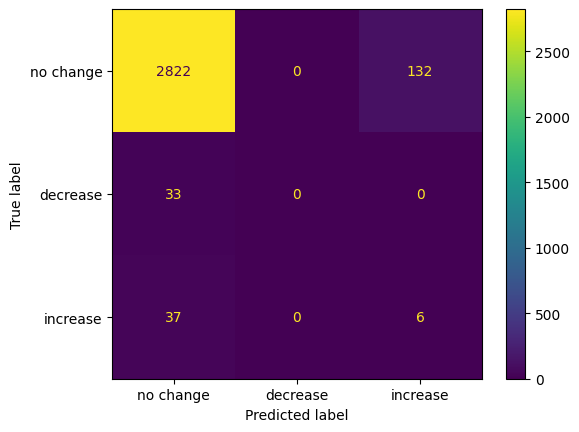

[Epoch 15] loss:	385.294, f1 train: 0.940, f1 test: 0.933 


In [66]:
num_epochs = 15
new_results = train(cnn, train_loader, test_loader, optimizer, criterion, num_epochs)

Overall, the performance is not satisfying. Due to the imbalanced dataset, the model only learns to classify "no change". Even after using weighte loss functions, we see more increase in predicting false positive.